In [1]:
import torch
from trainer import Trainer
from transformers import AdamW
import json
import os

%load_ext autoreload
%autoreload 2

# Load data

In [2]:
# python load data
from utils.pre_processing import combine_scraped_data
from config import DATA_PATHS
from utils.pre_processing import labels_indexes_mapping
from sklearn.model_selection import train_test_split

for phase in DATA_PATHS:
    metadata_name = DATA_PATHS[phase]['metadata']
    data_name = DATA_PATHS[phase]['data']
    combine_scraped_data(f'data/{data_name}', f'data/{metadata_name}', is_train=False)

In [3]:
from utils.pre_processing import clean_scraped_data_to_code
# TRAIN
train_base = clean_scraped_data_to_code('data/train_processed.xlsx')
# TEST
test = clean_scraped_data_to_code('data/test_processed.xlsx')

In [4]:
def clean_label_code(code: str) -> str:
    return code.split('.')[0][:-2]

train_base.loc[:, 'labels'] = train_base.labels.apply(clean_label_code)
test.loc[:, 'labels'] = test.labels.apply(clean_label_code)

# Create train, val, test

In [5]:
# # apply the label
# train_base.labels = train_base.labels.apply(lambda l: 'other' if l in low_freq_labels else l)
# test.labels = test.labels.apply(lambda l: 'other' if l in low_freq_labels else l)

In [6]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_base, test_size=0.25, shuffle=True, random_state=11)
train.shape, val.shape

((11597, 2), (3866, 2))

In [7]:
from utils.pre_processing import labels_indexes_mapping
label_to_idx, idx_to_label = labels_indexes_mapping(train_base)

In [8]:
# convert all string labels to number in order to train
from utils.pre_processing import labels_indexes_mapping
label_to_idx, idx_to_label = labels_indexes_mapping(train_base)

train.loc[:, 'labels'] = train.loc[:, 'labels'].apply(lambda x: label_to_idx.get(x))
val.loc[:, 'labels'] = val.labels.apply(lambda x: label_to_idx.get(x))
test.loc[:, 'labels'] = test.labels.apply(lambda x: label_to_idx.get(x))
train.shape, val.shape, test.shape

((11597, 2), (3866, 2), (15463, 2))

In [9]:
# convert the data to pytorch dataset
from datasets import TitlesDataset

train_ds = TitlesDataset(train.title.tolist(), train.labels.tolist())
val_ds = TitlesDataset(val.title.tolist(), val.labels.tolist())
test_ds = TitlesDataset(test.title.tolist(), test.labels.tolist())

## Evaluation

In [10]:
from torch.utils.data import DataLoader
batch_size = 16

train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_ds, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_ds, shuffle=True, batch_size=batch_size)

# Hyperparameter optimization
We are saving the best hp to `results` folder. If we already saved then the HP search will not run.

In [11]:
import optuna
from sklearn.metrics import f1_score
from models import BERT, tBERT
from utils.pre_processing import create_titles_corpus

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
N_TRAILS = 30
NUM_EPOCHS = 8

In [12]:
def bert_objective(trail):
    # Params ranges:
    embeddings_length = trail.suggest_categorical('embeddings_length', [32, 64])
    lr = trail.suggest_loguniform('lr', 1e-6, 1e-3)

    model = BERT(model_name='bert-base-uncased',num_labels=len(label_to_idx),
             max_length=embeddings_length, device=DEVICE)

    optimizer = AdamW(model.parameters(), lr=lr)

    trainer = Trainer(model=model, optimizer=optimizer, train_dataloader=train_dataloader, num_epochs=NUM_EPOCHS, device=DEVICE)

    trainer.train()
    labels, preds = trainer.evaluate(val_dataloader)
    f1 = f1_score(labels, preds, average='micro')
    return f1

if not os.path.isfile('results/BERT_best_params.json'):
    study = optuna.create_study(direction='maximize')
    study.optimize(bert_objective, n_trials=N_TRAILS)

    trail_ = study.best_trial
    with open('results/BERT_best_params.json', 'w') as f:
        d = dict(trail_.params)
        d['f1'] = trail_.values[0]
        json.dump(d, f, indent=4)
    print(f'BEST TRAIL:\n f1:  {trail_.values}\nparams: {trail_.params}')

## tBERT

In [13]:
def tbert_objective(trail):
    # PARAMS SETTING
    # Embedding
    embeddings_length = trail.suggest_categorical('embeddings_length', [32, 64])
    # General Model
    lr = trail.suggest_loguniform('lr', 1e-6, 1e-3)
    # LDA
    n_topics = trail.suggest_int('n_topics', 50, 500)
    alpha = trail.suggest_float('alpha', 1/50, 10)


    corpus = create_titles_corpus(train_dataloader)
    model = tBERT(corpus, model_name='bert-base-uncased',num_labels=len(label_to_idx),
             max_length=embeddings_length, n_topics=n_topics, alpha=alpha, device=DEVICE)

    optimizer = AdamW(model.parameters(), lr=lr)

    trainer = Trainer(model=model, optimizer=optimizer, train_dataloader=train_dataloader, num_epochs=NUM_EPOCHS, device=DEVICE)

    trainer.train()
    labels, preds = trainer.evaluate(val_dataloader)
    f1 = f1_score(labels, preds, average='micro')
    return f1

if not os.path.isfile('results/tBERT_best_params.json'):

    study = optuna.create_study(direction='maximize')
    study.optimize(tbert_objective, n_trials=N_TRAILS)

    trail_ = study.best_trial
    with open('results/tBERT_best_params.json', 'w') as f:
        d = dict(trail_.params)
        d['f1'] = trail_.values[0]
        json.dump(d, f, indent=4)
    print(f'BEST TRAIL:\n f1:  {trail_.values}\nparams: {trail_.params}')

# Train models with best parameters

In [14]:
from utils.metrics import show_results
NUM_EPOCHS = 20

## BERT

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/14500 [00:00<?, ?it/s]

  0%|          | 0/967 [00:00<?, ?it/s]

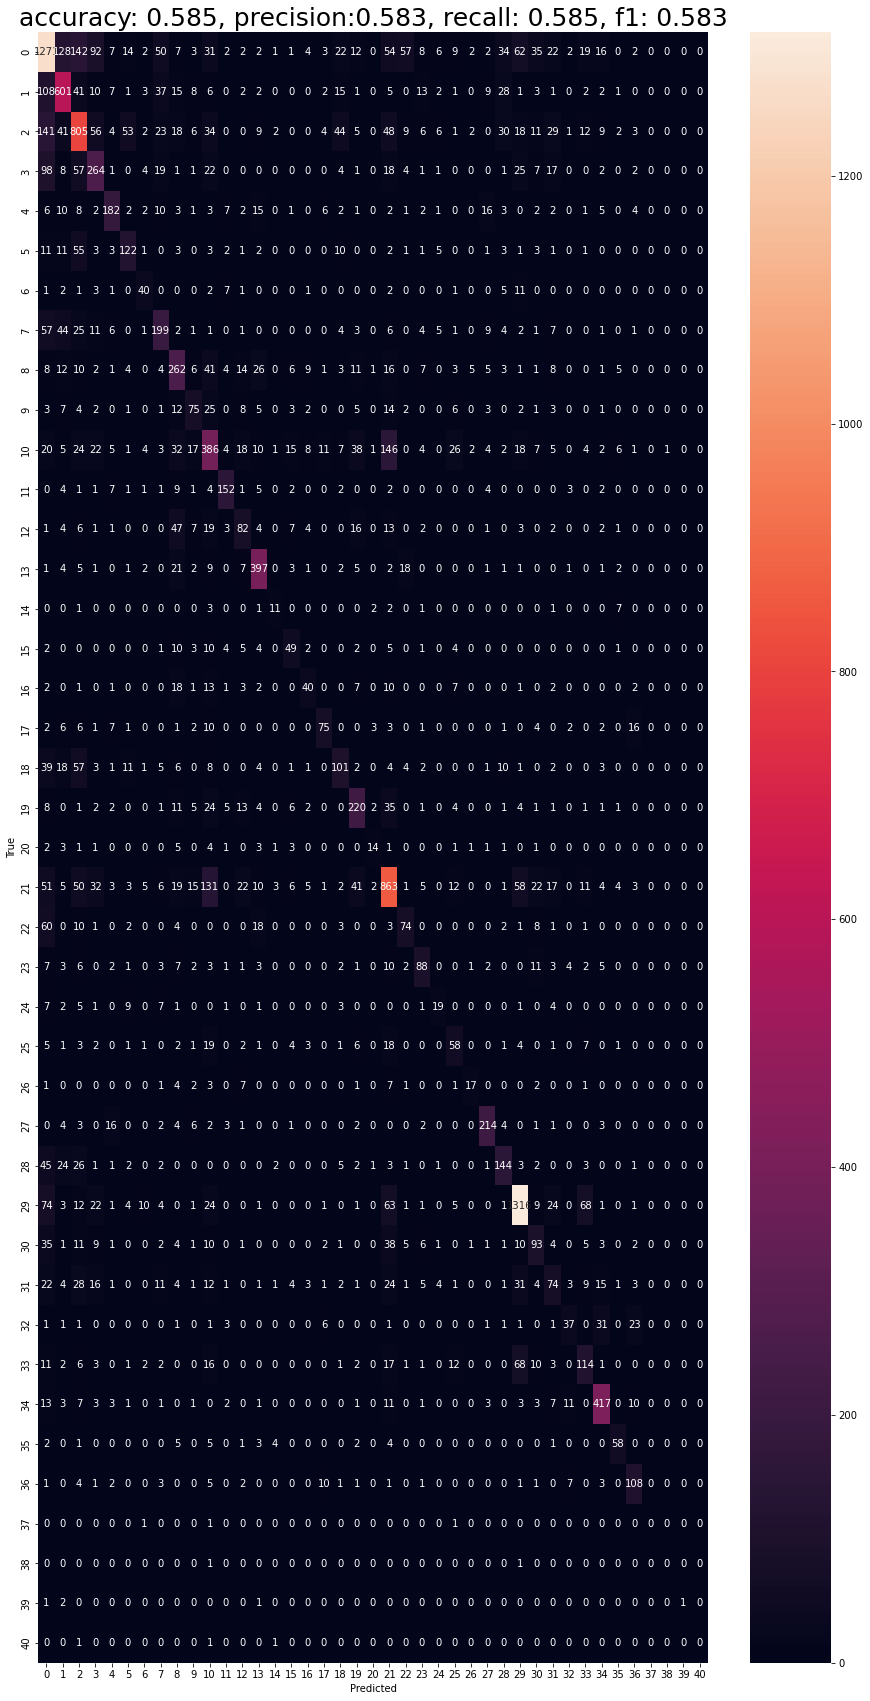

In [15]:
# get best parameters
with open('results/tBERT_best_params.json', 'r') as f:
    params = json.load(f)

model = BERT(model_name='bert-base-uncased',num_labels=len(label_to_idx),
         max_length=params['embeddings_length'], device=DEVICE)
optimizer = AdamW(model.parameters(), lr=params['lr'])
trainer = Trainer(model=model, optimizer=optimizer, train_dataloader=train_dataloader, num_epochs=NUM_EPOCHS, device=DEVICE)

trainer.train()

labels, preds = trainer.evaluate(test_dataloader)
show_results(labels, preds)

## tBERT

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/14500 [00:00<?, ?it/s]

  0%|          | 0/967 [00:00<?, ?it/s]

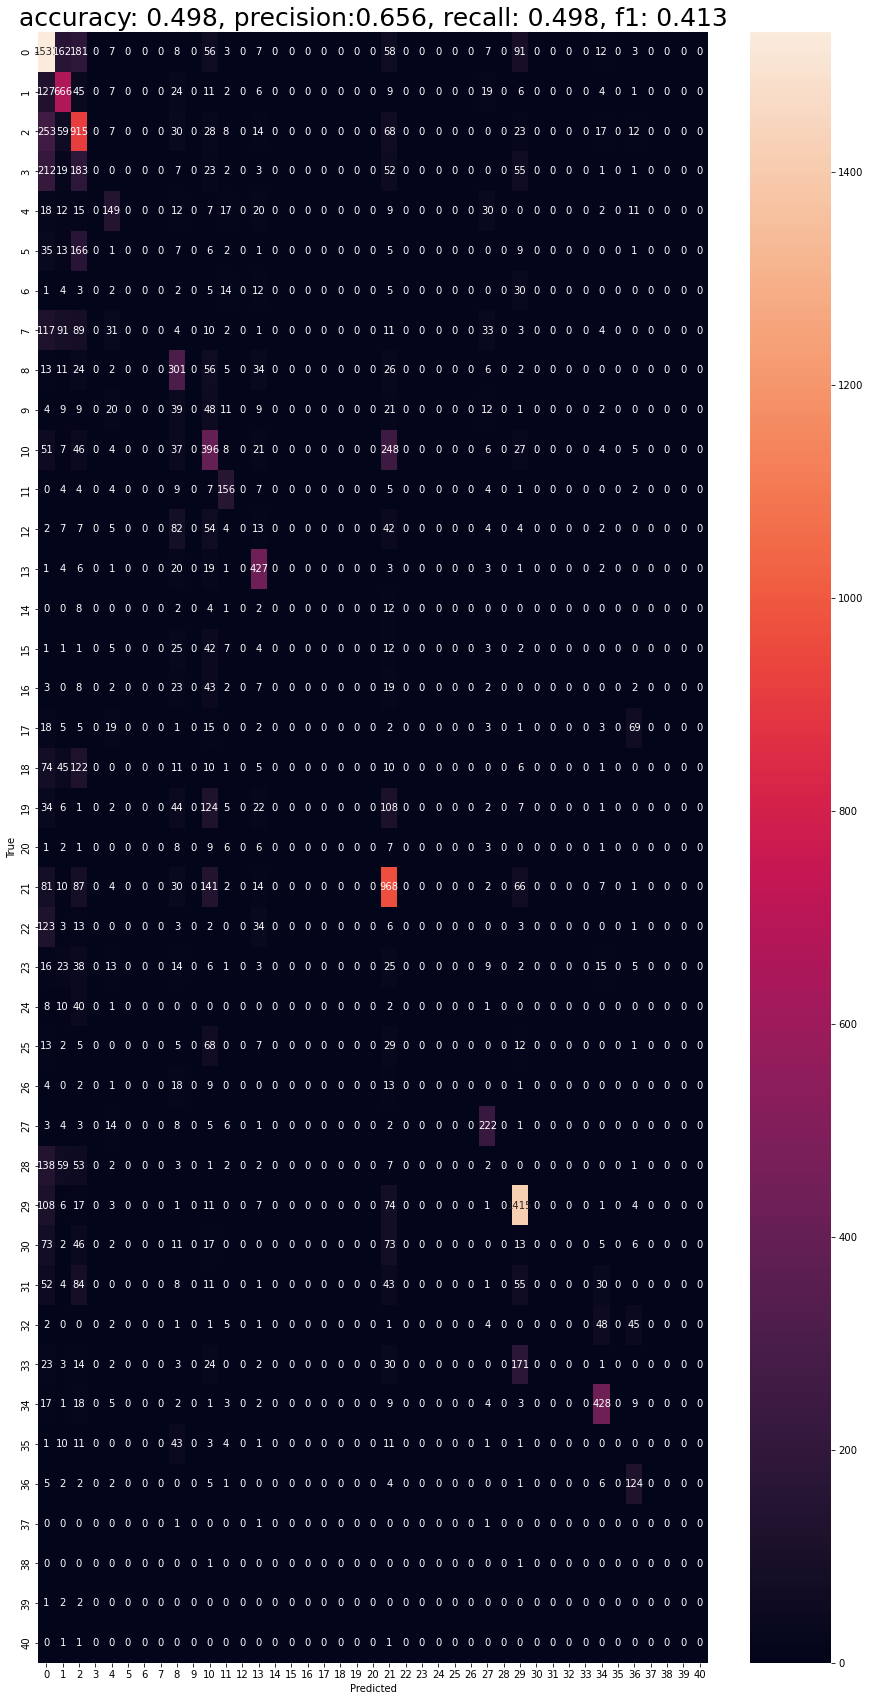

In [16]:
# get best parameters
with open('results/tBERT_best_params.json', 'r') as f:
    params = json.load(f)

# train tBERT
corpus = create_titles_corpus(train_dataloader)
model = tBERT(corpus, model_name='bert-base-uncased', num_labels=len(label_to_idx),
             max_length=params['embeddings_length'], n_topics=params['n_topics'], alpha=params['alpha'], device=DEVICE)
optimizer = AdamW(model.parameters(), lr=params['lr'])
trainer = Trainer(model=model, optimizer=optimizer, train_dataloader=train_dataloader, num_epochs=NUM_EPOCHS, device=DEVICE)

trainer.train()

labels, preds = trainer.evaluate(test_dataloader)
show_results(labels, preds)

In [25]:
# get best parameters
with open('results/BERT_best_params.json', 'r') as f:
    params = json.load(f)

for k, v in params.items():
    print(f'{k}: {v:.6f}')

embeddings_length: 64.000000
lr: 0.000067
f1: 0.591826


In [24]:
1e-5 == 0.00001

True